# Preâmbulo

Imports, funções, downloads e instalação do Pytorch.

In [ ]:
# Basic imports.
import os
import time
import numpy as np
import torch

import torch
from torch.autograd import Variable
import torch.nn.functional as F

from torch import nn
from torch import optim

from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn

from torchvision import models
from torchvision import datasets
from torchvision import transforms

from skimage import io

from sklearn import metrics

from matplotlib import pyplot as plt

%matplotlib inline

cudnn.benchmark = True

## Casting para o dispositivo correto

Como usaremos processamento vetorial principalmente em GPUs para aprendizado profundo, primeiramente é possível verificar se há uma GPU disponível com o trecho de código abaixo, armazenando os tensores nos dispositivos apropriados.

In [ ]:
# Checking if GPU/CUDA is available.
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


# Intro MLP

## O perceptron e a camada `nn.Linear`

A camada Linear do Pytorch ([nn.Linear](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear)) é responsável por aplicar uma transformação linear no dado de entrada. Esta camada recebe como parâmetro a dimensão (número de *features*) da entrada e da saída (que na verdade, representa o número de neurônios dessa camada). Por padrão o bias já é incluído. **Um** perceptron pode ser facilmente representado como a seguir, desconsiderando a função de ativação:

```
perceptron = nn.Linear(in_dimension, 1)
```
Mas de uma forma geral, uma camada Linear com diversas *features* de entrada e diversas *features* de saída pode ser representada como:
```
nn.Linear(in_features, out_features)
```
![](./figs/nn_linear.png)

In [ ]:
linear = nn.Linear(2,3)
print(linear)

Linear(in_features=2, out_features=3, bias=True)


Como é possível ver no código abaixo, o Pytorch já inicia os pesos da camada aleatoriamente.

In [ ]:
for p in linear.parameters():
  print(p)

Parameter containing:
tensor([[-0.1371,  0.4394],
        [ 0.3149,  0.4315],
        [-0.5239, -0.6747]], requires_grad=True)
Parameter containing:
tensor([ 0.2386, -0.3142,  0.4806], requires_grad=True)


O **forward** consiste em passar seu dado de entrada pela rede, gerando um resultado ao final. Considerando a camada linear instanciada anteriormente, o resultado do forward é o mesmo do somatório da multiplicação de seus pesos pelas respectivas entradas juntamente com o bias:

w1\*x1 + w2\*x2 + ... + wn\*xn + b

No Pytorch, realizamos o **forward** chamando a função onde nossa rede/modelo está instanciada, conforme exemplo abaixo.

In [ ]:
perceptron = nn.Linear(2,1)
X = torch.FloatTensor([2,3]) # dado de entrada de exemplo considerando o perceptron definido como nn.Linear(2,1)
print('Pytorch: ', perceptron(X))

# acessamos os pesos do modelo com .weight e o bias com .bias
print('Manual: ', torch.mul(X, perceptron.weight).sum() + perceptron.bias)

Pytorch:  tensor([1.1275], grad_fn=<AddBackward0>)
Manual:  tensor([1.1275], grad_fn=<AddBackward0>)


## Exemplo Perceptron simples

O código abaixo cria um perceptron simples usando `nn.Linear` e implemente o fluxo de treinamento para esse preceptron, ou seja, faz o forward nessa camada, calcula a loss, e otimiza a camada. Invista um pouco de tempo para entender a célula abaixo pois usaremos essa ideia para implementar a função de treino mais a frente.

In [ ]:
def loss_fn(predict, label):  # definindo a loss
    return torch.pow(label - predict, 2)

perceptron = nn.Linear(1,1) # Camada linear com 1 feature de entrada (mais o bias) e uma de saída
perceptron.to(device) # casting do perceptron para GPU
learning_rate = 0.01
print('Parametros iniciais: ', list(perceptron.parameters()))

dataset = [] # dados de exemplo que seguem a função y = 2x+3
for x in range(10):
    dataset.append((x, 2*x+3))

for epoch in range(101):
    epoch_loss = 0
    for iteration, data in enumerate(dataset):
        X, y = data
        X, y = torch.FloatTensor([X]).to(device), torch.FloatTensor([y]).to(device) # conversão para Tensor
  
        y_pred = perceptron(X)  # forward
        loss = loss_fn(y_pred, y)  # calcula a loss

        epoch_loss += loss.item()
        loss.backward()
        with torch.no_grad():
            for param in perceptron.parameters():
                param -= learning_rate * param.grad  # atualização dos parametros (pesos e bias) com base no gradiente
                param.grad.zero_()  # resetando o gradiente

    if epoch % 10 == 0:
        print("Epoch {} - loss: {}".format(epoch, epoch_loss))
print('Parametros finais: ', list(perceptron.parameters()))

Parametros iniciais:  [Parameter containing:
tensor([[-0.0700]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.9873], device='cuda:0', requires_grad=True)]
Epoch 0 - loss: 288.4102809987962
Epoch 10 - loss: 10.214067387394607
Epoch 20 - loss: 3.5298936692997813
Epoch 30 - loss: 1.219899281160906
Epoch 40 - loss: 0.42158502485835925
Epoch 50 - loss: 0.14569592762563843
Epoch 60 - loss: 0.05035081384994555
Epoch 70 - loss: 0.01740083147888072
Epoch 80 - loss: 0.006013804901158437
Epoch 90 - loss: 0.0020783275831490755
Epoch 100 - loss: 0.0007182354429460247
Parametros finais:  [Parameter containing:
tensor([[2.0016]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([2.9845], device='cuda:0', requires_grad=True)]


In [ ]:
print(perceptron(torch.FloatTensor([20]).to(device))) # forward do valor 20 para conferir resultado, saida deve ser aproximadamente = 2x+3 = 2*20+3 = 43

tensor([43.0172], device='cuda:0', grad_fn=<AddBackward0>)


## O módulo `nn.Sequential`

Na prática, criaremos redes com diversas camadas. O bloco `nn.Sequential` permite agrupar as camadas de forma sequencial para que o forward seja realizado na ordem desejada. Veja um exemplo para um *Multilayer Perceptron (MLP)* abaixo.

In [ ]:
in_features = 28
hidden_1 = 64
hidden_2 = 32
out_features = 8

MLP = nn.Sequential(nn.Linear(in_features, hidden_1), nn.ReLU(), 
                    nn.Linear(hidden_1, hidden_2), nn.ReLU(), 
                    nn.Linear(hidden_2, out_features))
print(MLP)

Sequential(
  (0): Linear(in_features=28, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=8, bias=True)
)


In [ ]:
test_data = torch.randn((10,28)) # 10 dados de input aleatórios com 28 features
output = MLP(test_data) # forward da rede
print(output.size())

torch.Size([10, 8])


## Sua vez

Vamos agora treinar um MLP simples em dados aleatórios. A célula abaixo define as dimensões de entrada e saída e gera os dados aleatórios.

In [ ]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Casting tensors to the appropriate device.
x = x.to(device)
y = y.to(device)

# Printing sizes of tensors.
print('x: ', x.size())
print('y: ', y.size())

x:  torch.Size([64, 1000])
y:  torch.Size([64, 10])


Modifique o código abaixo para criar um módulo `nn.Sequential` de nome **model** que representa um MLP com, pelo menos, uma camada escondida (seguindo os valores N, D_in, H e D_out definidos anteriormente), **usando um ReLU como função de ativação entre as camadas**.


In [ ]:
model = nn.Sequential(nn.Linear(D_in, H), nn.ReLU(), 
                      nn.Linear(H, H), nn.ReLU(), 
                      nn.Linear(H, D_out))

model.to(device)  # sempre eh necessario fazer o casting da rede para joga-la para GPU
print(model)

Sequential(
  (0): Linear(in_features=1000, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=10, bias=True)
)


Abaixo, definimos uma loss e um otimizador usando o Torch. Não se preocupem como isso agora, pois iremos ver em detalhes como definir e usar diferentes losses and otimizadores com o Torch.

In [ ]:
# Use the nn package to define our loss function.
loss_mse = nn.MSELoss(reduction='sum').to(device)

In [ ]:
# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use SGD; the optim package contains many other
# optimization algorithms. The first argument tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

Implemente abaixo a forward e cálculo da loss como feito anteriormente. Estude essa função, pois usaremos esse fluxo de treino mais a frente.

In [ ]:
# Creating list of losses for each epoch.
loss_list = []

# Iterating over epochs.
for epoch in range(500):

    preds = model(x)
    loss = loss_mse(preds, y)

    if (epoch + 1) % 10 == 0:
        print('Epoch ' + str(epoch + 1) + ': loss = ' + str(loss.item()))
    
    # Updating list of losses for printing.
    loss_list.append(loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

Epoch 10: loss = 550.152099609375
Epoch 20: loss = 491.513916015625
Epoch 30: loss = 432.72039794921875
Epoch 40: loss = 369.6939697265625
Epoch 50: loss = 302.154541015625
Epoch 60: loss = 234.55767822265625
Epoch 70: loss = 173.6392822265625
Epoch 80: loss = 124.05020141601562
Epoch 90: loss = 86.89012145996094
Epoch 100: loss = 60.46564483642578
Epoch 110: loss = 42.45393371582031
Epoch 120: loss = 30.2360897064209
Epoch 130: loss = 21.7821102142334
Epoch 140: loss = 15.816312789916992
Epoch 150: loss = 11.538751602172852
Epoch 160: loss = 8.483081817626953
Epoch 170: loss = 6.273039817810059
Epoch 180: loss = 4.66347599029541
Epoch 190: loss = 3.4928414821624756
Epoch 200: loss = 2.6250698566436768
Epoch 210: loss = 1.9842159748077393
Epoch 220: loss = 1.5087389945983887
Epoch 230: loss = 1.1542065143585205
Epoch 240: loss = 0.8890576362609863
Epoch 250: loss = 0.6898928880691528
Epoch 260: loss = 0.5392681360244751
Epoch 270: loss = 0.42409276962280273
Epoch 280: loss = 0.33519977

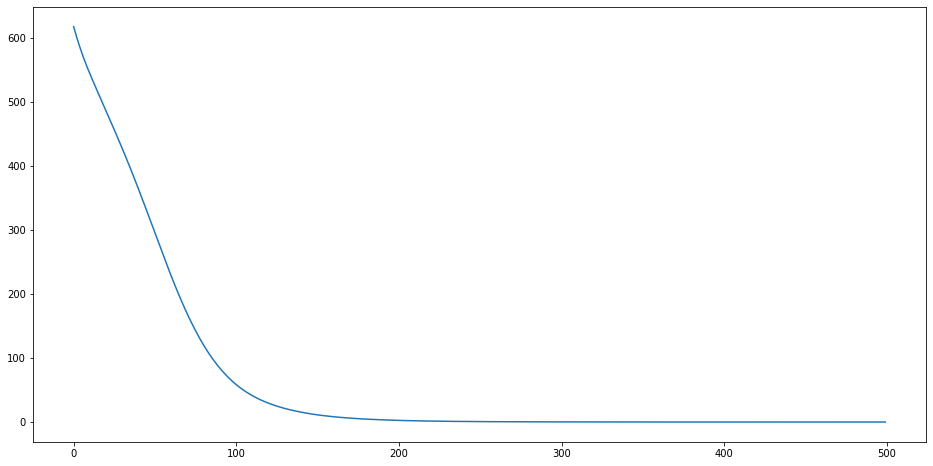

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.plot(np.asarray(loss_list))

plt.show()

Informação sobre outras camadas lineares, como nn.Bilinear e nn.Identity, podem ser vistas na documentação: https://pytorch.org/docs/stable/nn.html#linear-layers